### A/B Testing: Step by Step & Hypothesis Testing

##### 2020710058 Applied Data Science Doo-yeonog, Lee

In [3]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")

In [4]:
path = "cookie_cats.csv"
    
ab = pd.read_csv(path)
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# Number of Unique User
ab.userid.nunique() == ab.shape[0]

True

In [6]:
# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


In [7]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.456264,256.716423,49854
gate_40,45489,16,51.298776,103.294416,2640


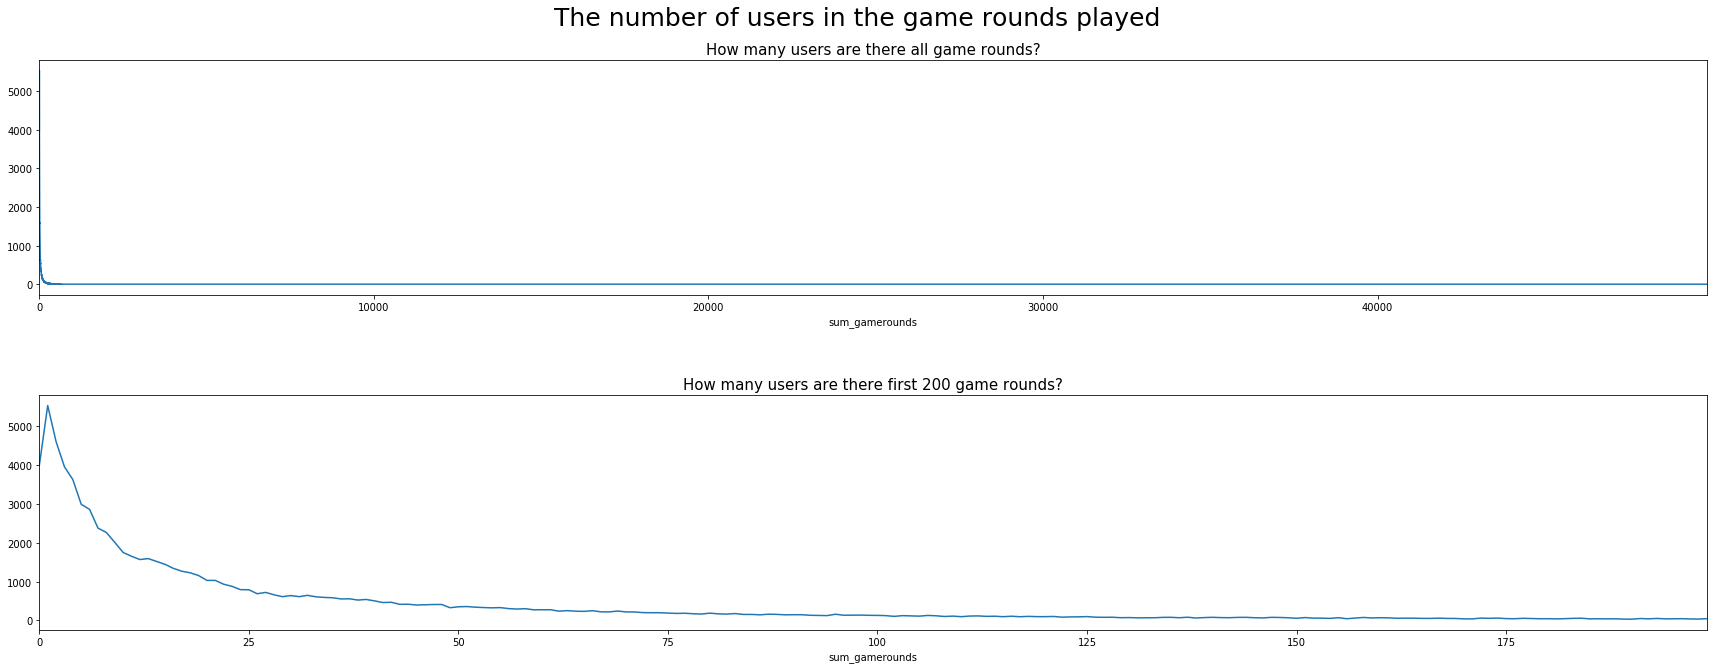

In [8]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
ab.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
ab.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

In [9]:
ab.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [10]:
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,2961.0


In [11]:
# How many users reached gate 30 & gate 40 levels?
ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [12]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17,51.342111,102.057598,2961
gate_40,45489,16,51.298776,103.294416,2640


In [13]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": ab["retention_1"].value_counts(),
              "RET7_COUNT": ab["retention_7"].value_counts(),
              "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),
              "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


In [14]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665       6  16.359092   36.528426  1072
        True         20034      48  94.411700  135.037697  2961
gate_40 False        25370       6  16.340402   35.925756  1241
        True         20119      49  95.381182  137.887256  2640

In [15]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198      11   25.796508   43.316158   981
        True          8501     105  160.117516  179.358560  2961
gate_40 False        37210      11   25.856356   44.406112  2640
        True          8279     111  165.649837  183.792499  2294

Similar results are seen when the number of users who came and did not come 1 day and 7 days after the game was installing. Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 14% of the total users include people who will continue the game in the future.

In [16]:
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version Retention                                             
gate_30 0          38023      12   28.070273   48.017452  1072
        1           6676     127  183.886309  189.626390  2961
gate_40 0          38983      12   28.103353   48.927850  2640
        1           6506     133  190.282355  194.220077  2294

In [17]:
ab["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), ab.retention_1, ab.retention_7))
ab.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6,11.819746,21.642643,981
1,gate_30,False-True,1825,43,73.169315,93.222330,1072
2,gate_30,True-False,13358,33,49.694490,58.125396,918
3,gate_30,True-True,6676,127,183.886309,189.626390,2961
4,gate_40,False-False,23597,6,11.913294,20.901020,547
5,gate_40,False-True,1773,47,75.261139,94.478048,1241
6,gate_40,True-False,13613,32,50.025490,60.924587,2640
7,gate_40,True-True,6506,133,190.282355,194.220077,2294


In [18]:
# Define A/B groups
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [19]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=ab, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025446,A/B groups are not similar!
